In [22]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
import geocat.comp
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4
import os
import proplot as pplt
from numpy import meshgrid, deg2rad, gradient, cos, sin
from xarray import DataArray
from scipy import stats
from sklearn.preprocessing import StandardScaler as scale
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.interpolate import griddata
import xesmf as xe
import warnings
warnings.filterwarnings('ignore')

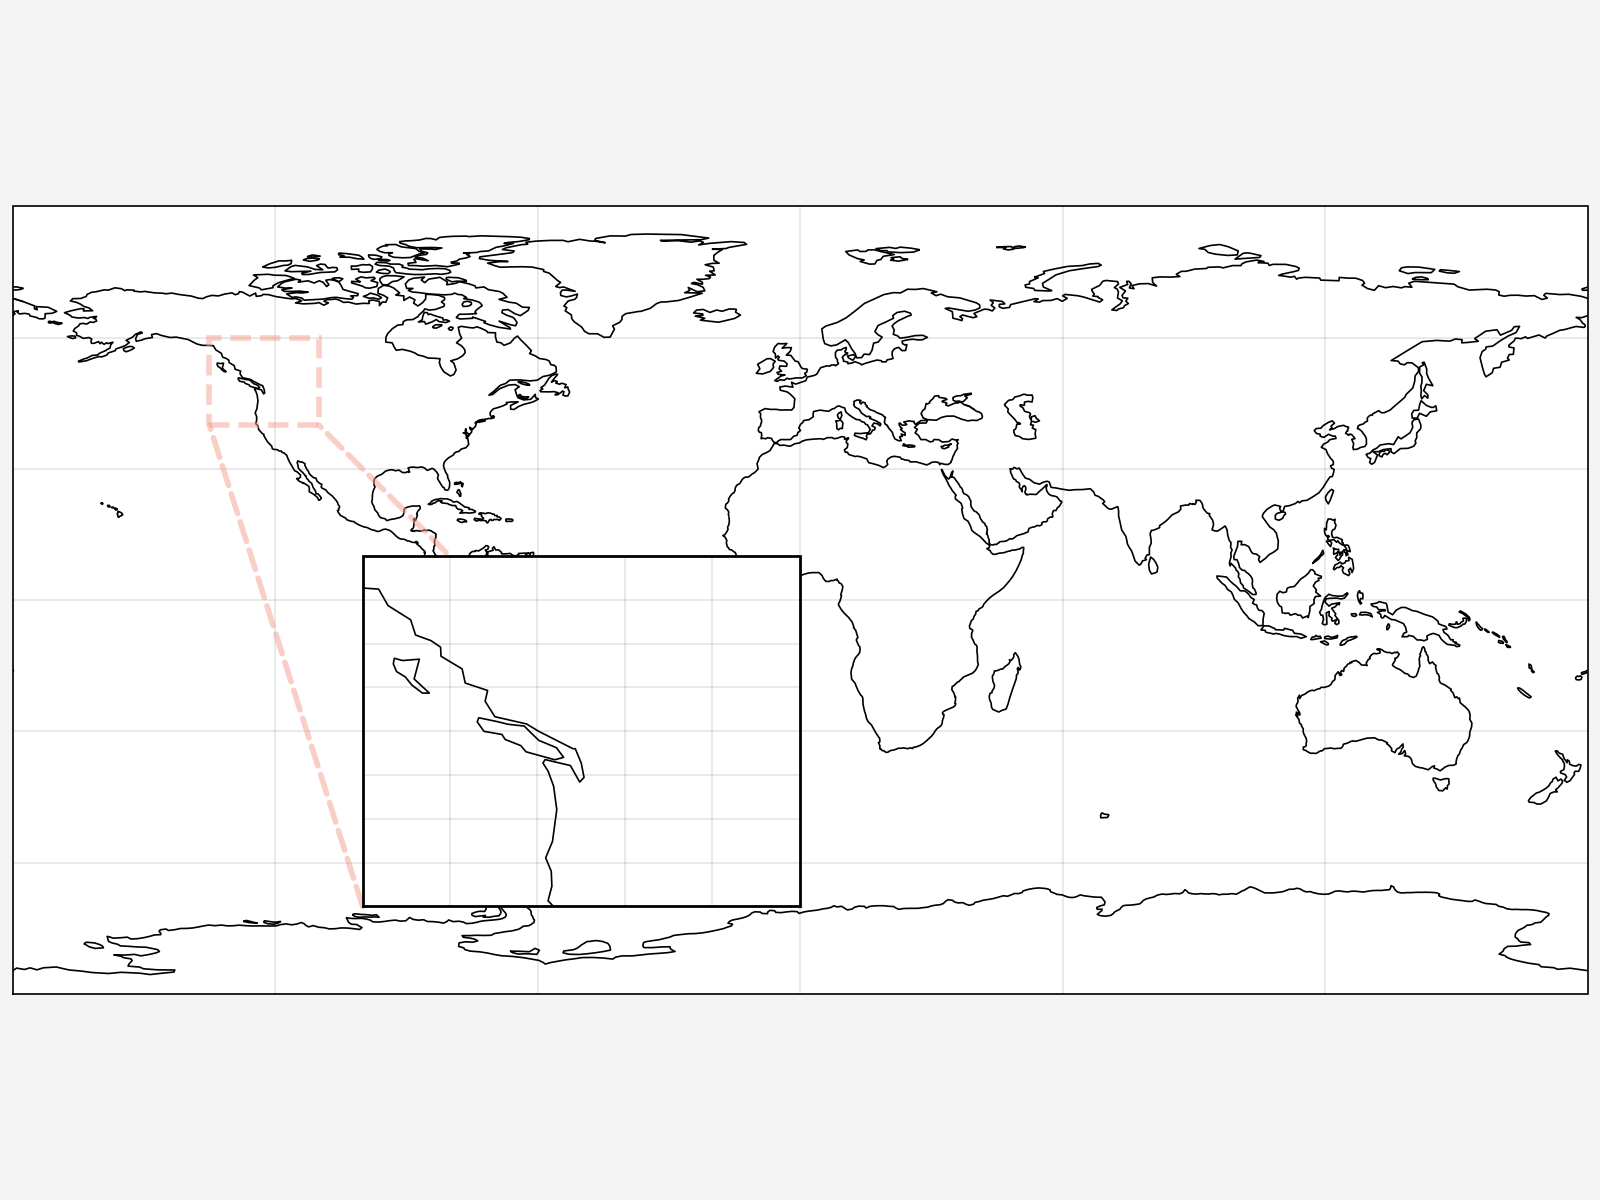

In [23]:
#Plot a map of the area we are looking at
#fig,axes=pplt.subplots([[1]],proj='cyl')
fig,axes=pplt.subplots(figsize=(8,6),proj='cyl')
fig.format(coast=True)

ix = axes.inset(
    [-100,-80,100,100], transform='data', zoom=True,
    zoom_kw={'ec': 'blush', 'ls': '--', 'lw': 2}
)
ix.format(coast=True,
    xlim=(60,10), ylim=(10,30), color='black',
    linewidth=1, ticklabelweight='bold'
)
ix.format(lonlim=(225,250), latlim=(40, 60))

fig.save('PacificNW_Map')

In [24]:
#3D detrend function
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
    
#1D detrend function
def altdetrend(x:np.ndarray,time:np.ndarray):
        nt = x.shape
        xtemp = x.reshape(nt)
        p = np.polyfit(time, x, deg=1)
        fit = p[0]*(time[:,np.newaxis])+ p[1]
        return x - fit.reshape(nt)
    
def remove_time_mean(x):
        return x - x.mean(dim='time')

def removeSC(x):
        return x.groupby('time.month').apply(remove_time_mean)
    
def calStdNorAnom(x):
    for m in np.unique(x.time.dt.month):
        mData=x[x.time.dt.month==m]
        mRolling=mData.mean()
        sRolling=mData.std()
        normData=(mData-mRolling)/sRolling
    return normData

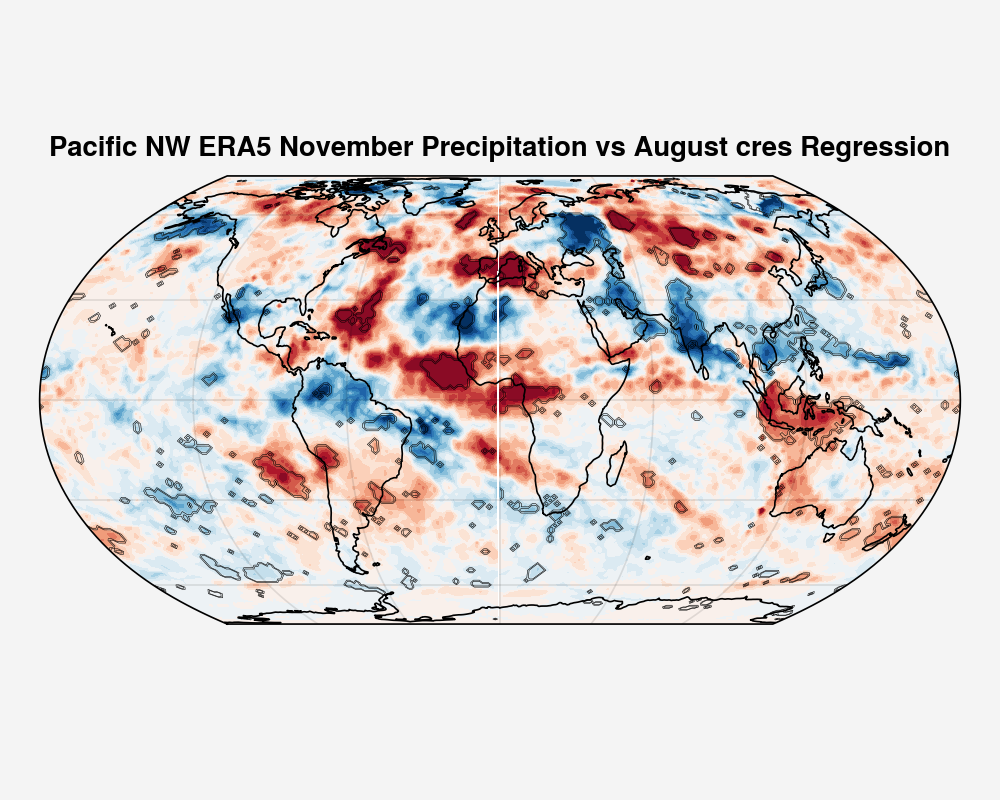

In [42]:
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
#Open ERA5 Dataset
data=xr.open_dataset(files)
cres=data.cres
cresSurf=data.cresSurf
netTOA=data.netTOA
crel=data.crel
crelSurf=data.crelSurf
pr=data.pr
land=data.lsMask

lat=cres.lat
lon=cres.lon



time=cres.time
land=land.sel(lon=slice(225,250),lat=slice(40,60))

#Select Monsoon Months
months=[11]
lagmonths=[8]
#months=[7]
#lagmonths=[5]
#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
cres=cres.where(cres.time.dt.month.isin(lagmonths), drop=True)

plottime=prec.time

#Select only the Pacific NW Region
precip=prec.sel(lon=slice(225,250),lat=slice(40,60))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

#Remove seasonal cycle
cres=removeSC(cres)
prec_index=removeSC(prec_index)

#Normalize
cres=calStdNorAnom(cres)
prec_index=calStdNorAnom(prec_index)

#Detrend data sets
time=cres.time
cres=cres.to_numpy()
prec_index=prec_index.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

cres=detrend(cres,time)
#cres=np.roll(cres,120,axis=2)
cres=xr.DataArray(cres,coords=[time,lat,lon],dims=['time','lat','lon'])

prec_index=altdetrend(prec_index,time)
prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])


mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,cres = xr.broadcast(prec_index,cres) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,cres,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,cres,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )

intercepts=xr.apply_ufunc(ints,
                    pr_new,cres,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots(figsize=(5,4),proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-1,1,0.1),extend='both')
corrs1=axes.contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation
corrs2=axes.contour(corr1.lon,corr1.lat,corr2,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
#cbar=plt.colorbar(con)
axes.format(suptitle='Pacific NW ERA5 November Precipitation vs August cres Regression')
#axes.format(suptitle='South Asia ERA5 Monsoon Precipitation vs Feb-May cres Regression')
#cbar.set_label('Regression')
#fig.save('ERA5_NovPrec_AugCRES_Regression')
#fig.save('ERA5_SAMonsoon_FebtoMay_Cres_Regression')

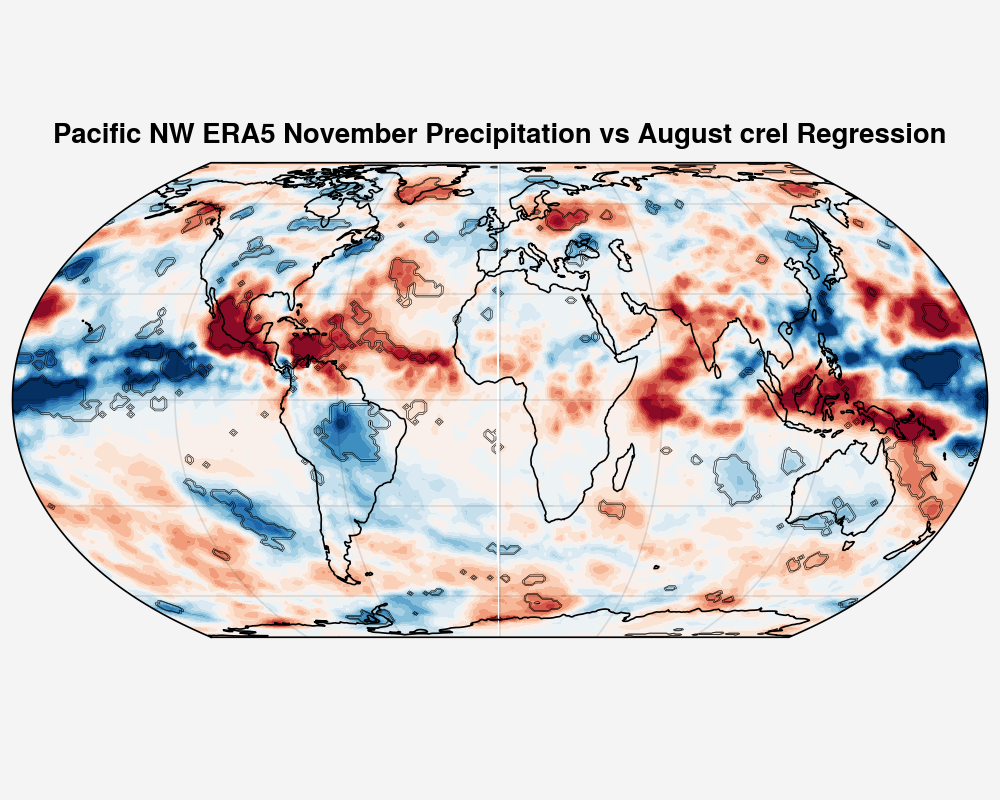

In [20]:
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
#Open ERA5 Dataset
data=xr.open_dataset(files)
netTOA=data.netTOA
crel=data.crel
crelSurf=data.crelSurf
pr=data.pr
land=data.lsMask

lat=crel.lat
lon=crel.lon
time=crel.time
land=land.sel(lon=slice(225,250),lat=slice(40,60))

#Select Monsoon Months
months=[11]
lagmonths=[8]
#months=[7]
#lagmonths=[5]
#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
crel=crel.where(crel.time.dt.month.isin(lagmonths), drop=True)

plottime=prec.time

#Select only the Pacific NW Region
precip=prec.sel(lon=slice(225,250),lat=slice(40,60))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

#Remove seasonal cycle
crel=removeSC(crel)
prec_index=removeSC(prec_index)

#Normalize
crel=calStdNorAnom(crel)
prec_index=calStdNorAnom(prec_index)

#Detrend data sets
time=crel.time
crel=crel.to_numpy()
prec_index=prec_index.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

crel=detrend(crel,time)
crel=xr.DataArray(crel,coords=[time,lat,lon],dims=['time','lat','lon'])

prec_index=altdetrend(prec_index,time)
prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])


mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,crel = xr.broadcast(prec_index,crel) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,crel,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,crel,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )

intercepts=xr.apply_ufunc(ints,
                    pr_new,crel,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots(figsize=(5,4),proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-1,1,0.1),extend='both')
corrs1=axes.contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation
corrs2=axes.contour(corr1.lon,corr1.lat,corr2,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
#cbar=plt.colorbar(con)
axes.format(suptitle='Pacific NW ERA5 November Precipitation vs August crel Regression')
#axes.format(suptitle='South Asia ERA5 Monsoon Precipitation vs Feb-May crel Regression')
#cbar.set_label('Regression')
fig.save('ERA5_NovPrec_Augcrel_Regression')
#fig.save('ERA5_SAMonsoon_FebtoMay_crel_Regression')

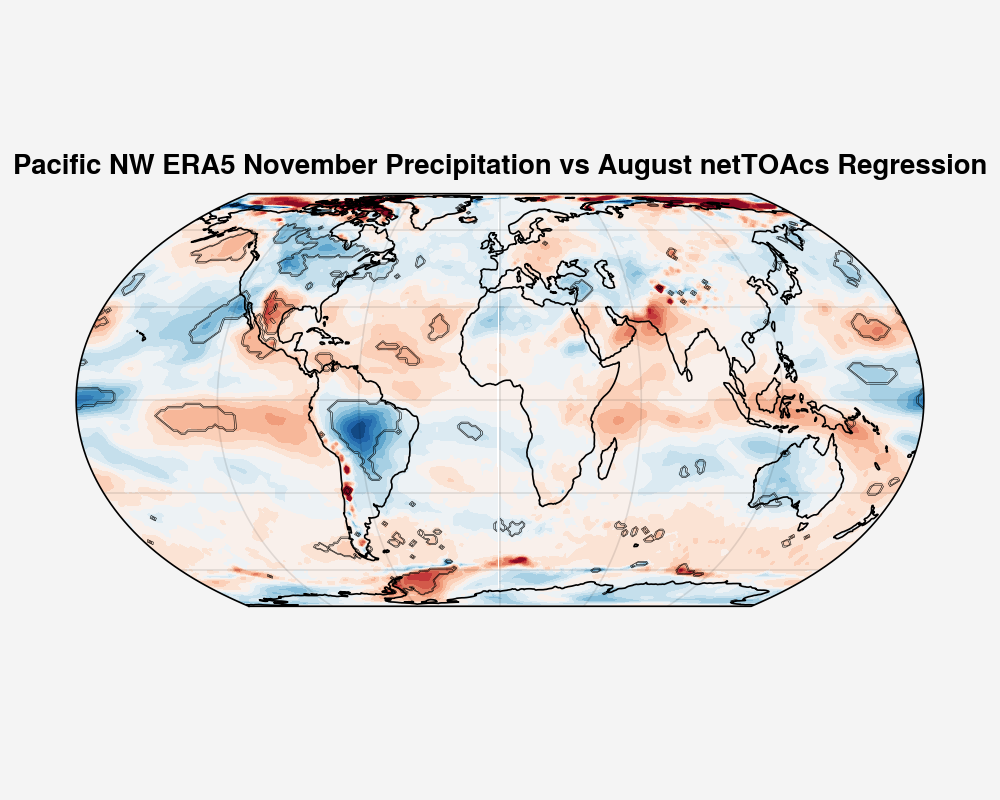

In [21]:
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
#Open ERA5 Dataset
data=xr.open_dataset(files)
netTOAcs=data.netTOAcs
pr=data.pr
land=data.lsMask

lat=netTOAcs.lat
lon=netTOAcs.lon
time=netTOAcs.time
land=land.sel(lon=slice(225,250),lat=slice(40,60))

#Select Monsoon Months
months=[11]
lagmonths=[8]
#months=[7]
#lagmonths=[5]
#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
netTOAcs=netTOAcs.where(netTOAcs.time.dt.month.isin(lagmonths), drop=True)

plottime=prec.time

#Select only the Pacific NW Region
precip=prec.sel(lon=slice(225,250),lat=slice(40,60))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

#Remove seasonal cycle
netTOAcs=removeSC(netTOAcs)
prec_index=removeSC(prec_index)

#Normalize
netTOAcs=calStdNorAnom(netTOAcs)
prec_index=calStdNorAnom(prec_index)

#Detrend data sets
time=netTOAcs.time
netTOAcs=netTOAcs.to_numpy()
prec_index=prec_index.to_numpy()
time=time.to_numpy()
time=time.astype(int)/10**9

netTOAcs=detrend(netTOAcs,time)
netTOAcs=xr.DataArray(netTOAcs,coords=[time,lat,lon],dims=['time','lat','lon'])

prec_index=altdetrend(prec_index,time)
prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])


mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,netTOAcs = xr.broadcast(prec_index,netTOAcs) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,netTOAcs,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,netTOAcs,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )

intercepts=xr.apply_ufunc(ints,
                    pr_new,netTOAcs,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots(figsize=(5,4),proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-1,1,0.1),extend='both')
corrs1=axes.contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation
corrs2=axes.contour(corr1.lon,corr1.lat,corr2,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
#cbar=plt.colorbar(con)
axes.format(suptitle='Pacific NW ERA5 November Precipitation vs August netTOAcs Regression')
#axes.format(suptitle='South Asia ERA5 Monsoon Precipitation vs Feb-May netTOAcs Regression')
#cbar.set_label('Regression')
fig.save('ERA5_NovPrec_AugnetTOAcs_Regression')
#fig.save('ERA5_SAMonsoon_FebtoMay_netTOAcs_Regression')

In [31]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)

## By downloading the master CSV file enumerating all available data stores, we can interact with the spreadsheet
## through a pandas DataFrame to search and explore for relevant data using the CMIP6 controlled vocabulary:

df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

In [32]:
def getData(qstring):
    df_subset = df.query(qstring)
    if df_subset.empty:
        print('data not available for '+qstring)
    else:
        for v in df_subset.zstore.values:
            zstore = v
            mapper = fs.get_mapper(zstore)
            return_ds = xr.open_zarr(mapper, consolidated=True)
    return(return_ds)

In [33]:
#Load in ERA5 data for land mask
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
data=xr.open_dataset(files)
land=data.lsMask
land=land[:432,:,:]

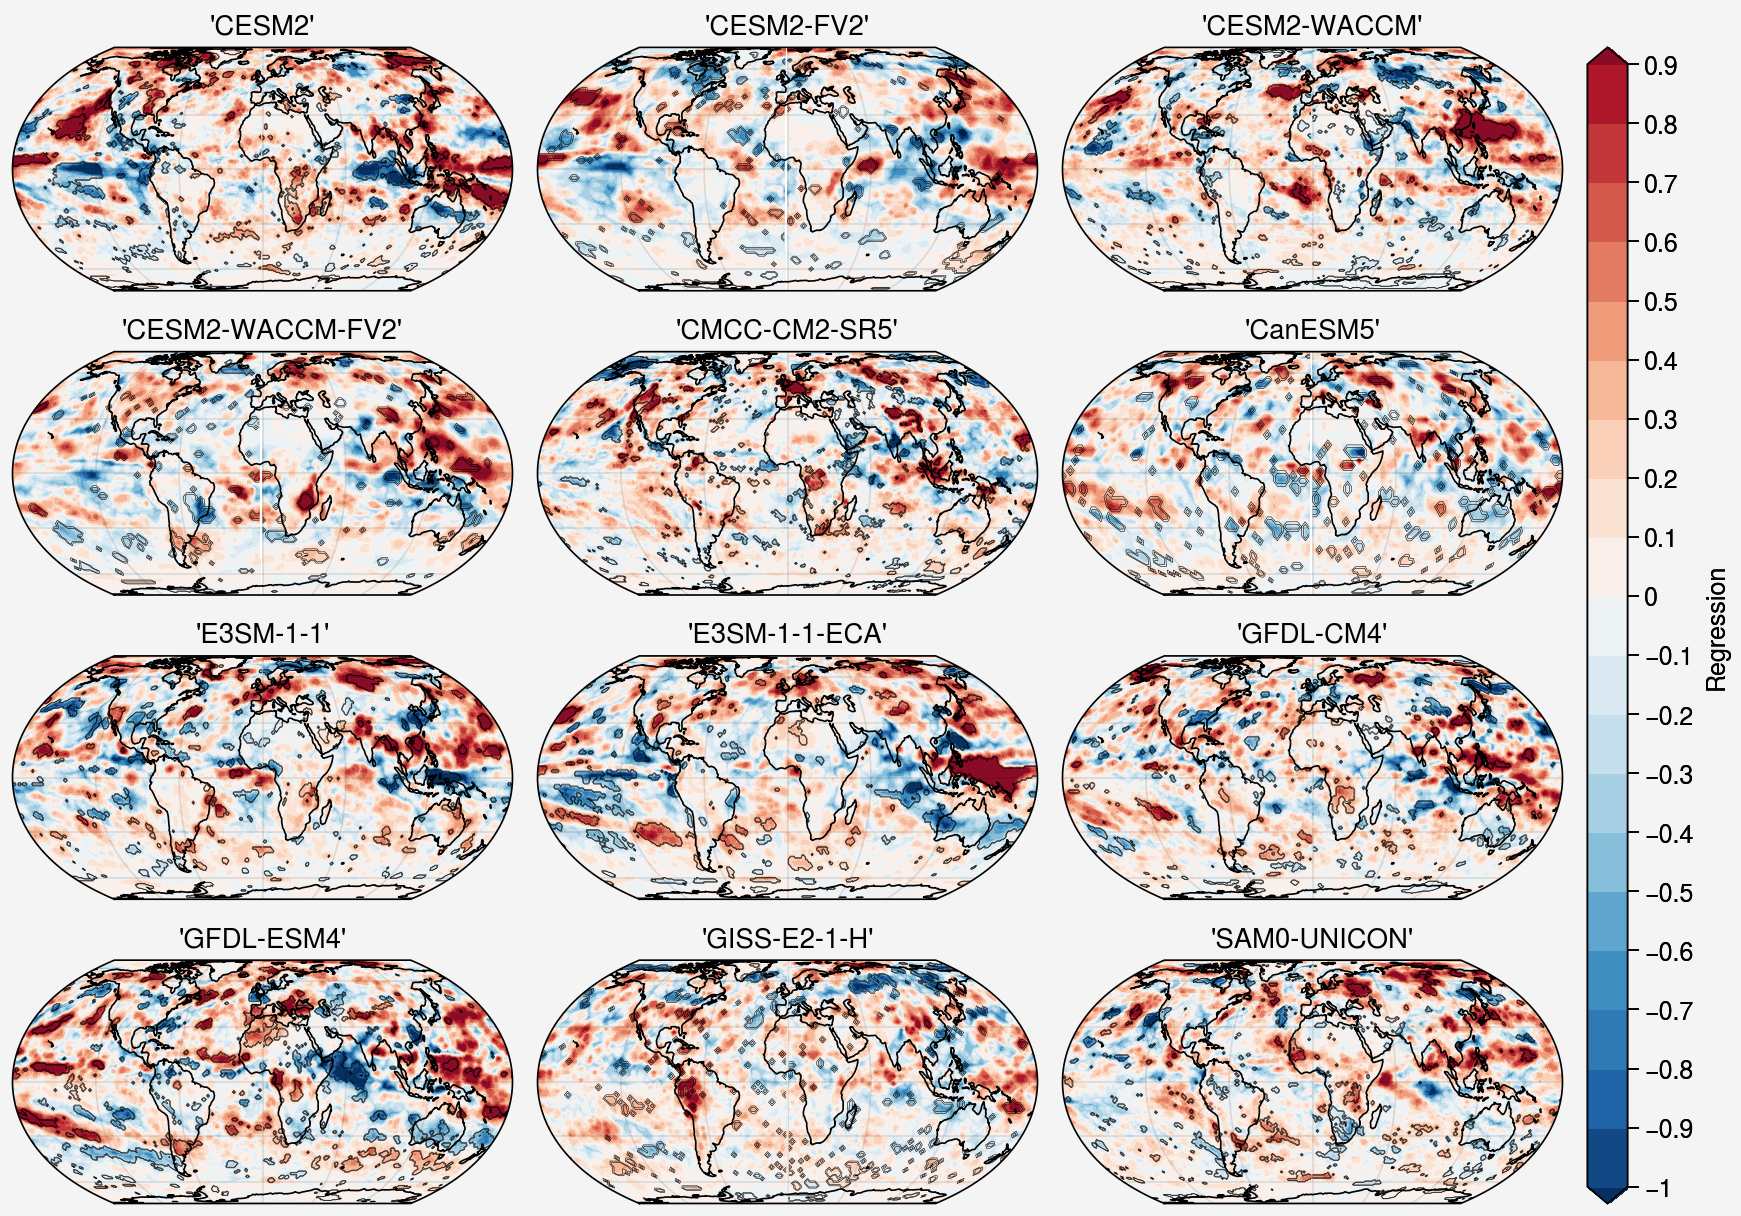

In [34]:
#Load in model data

#modelNames=["'CESM2'","'CESM2-FV2'","'CESM2-WACCM'","'CESM2-WACCM-FV2'","'CMCC-CM2-SR5'","'CanESM5'",
#"'E3SM-1-1'","'E3SM-1-1-ECA'","'GFDL-CM4'","'GFDL-ESM4'","'GISS-E2-1-H'","'SAM0-UNICON'","'TaiESM1'"
#,"'HadGEM3-GC31-MM'","'EC-Earth3P'","'BCC-CSM2-HR'"]

modelNames=["'CESM2'","'CESM2-FV2'","'CESM2-WACCM'","'CESM2-WACCM-FV2'","'CMCC-CM2-SR5'","'CanESM5'",
"'E3SM-1-1'","'E3SM-1-1-ECA'","'GFDL-CM4'","'GFDL-ESM4'","'GISS-E2-1-H'","'SAM0-UNICON'"]

membList=["'r1i1p1f1'"]

#fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],proj='eqearth')
fig,axes = pplt.subplots([[1,2,3],[4,5,6],[7,8,9],[10,11,12]],proj='eqearth')
for j, name in enumerate(modelNames):
        inputStr = "activity_id=='CMIP' & table_id=='Amon' & source_id=="+name+" & experiment_id=='historical' & member_id=='r1i1p1f1' & variable_id=="
        #altinputStr  = "activity_id=='CMIP' & table_id=='fx' & source_id=="+name+" & experiment_id=='historical' &  member_id=='r1i1p1f1' & variable_id=="
        rsut_ds   = getData(inputStr+"'rsut'")
        pr_ds     = getData(inputStr+"'pr'")
        rsutcs_ds = getData(inputStr+"'rsutcs'")
        #sftlf_ds = getData(altinputStr+"'sftlf'")

        cres= rsutcs_ds.rsutcs-rsut_ds.rsut
        prec=pr_ds.pr
        cres=cres[1548:,:,:]
        prec=prec[1548:,:,:]

        datetimeindex=cres.indexes['time'].to_datetimeindex()
        cres['time']=datetimeindex

        lat=prec.lat
        lon=prec.lon

        time=prec.time


        #Perhaps regrid everything to a standard grid then take out the land idk. 
        ds_target = xr.Dataset({'time':(['time'],time.data),'lat':(['lat'],lat.data),'lon':(['lon'],lon.data)})

        regridder = xe.Regridder(land,ds_target,'bilinear',periodic=True)
        regridland = regridder(land)
        regridland=xr.DataArray(regridland,coords=[time,lat,lon],dims=['time','lat','lon'])

        regridder1 = xe.Regridder(cres,ds_target,'bilinear',periodic=True)
        regridcres = regridder1(cres)
        cres=xr.DataArray(regridcres,coords=[time,lat,lon],dims=['time','lat','lon'])

        precip=xr.where(regridland==0,np.nan,prec) #remove oceans, monsoon is defined as only over land  


        #Select Monsoon Months
        months=[11]
        lagmonths=[8]
        #varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
        prec=precip.where(precip.time.dt.month.isin(months), drop=True)
        #land=regridland.where(regridland.time.dt.month.isin(months), drop=True)
        cres=cres.where(cres.time.dt.month.isin(lagmonths), drop=True)

        #Select only the SAM lat,lon range: 60-100E, 10-30N
        precip=prec.sel(lon=slice(225,250),lat=slice(40,60))

        #Do weighted correction on precipitation
        weights=np.cos(np.deg2rad(precip.lat))
        prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
        prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

        #Remove seasonal cycle
        cres=removeSC(cres)
        prec_index=removeSC(prec_index)

        #Normalize
        cres=calStdNorAnom(cres)
        prec_index=calStdNorAnom(prec_index)

        
        #Convert time type 
        datetimeindex=cres.indexes['time'].to_datetimeindex()
        cres['time']=datetimeindex
        
        #Detrend data sets
        time=cres.time
        cres=cres.to_numpy()
        prec_index=prec_index.to_numpy()
        time=time.to_numpy()
        time=time.astype(int)/10**9

        cres=detrend(cres,time)
        cres=xr.DataArray(cres,coords=[time,lat,lon],dims=['time','lat','lon'])

        prec_index=altdetrend(prec_index,time)
        prec_index=xr.DataArray(prec_index,coords=[time],dims=['time'])

        mystd=prec_index.std()
        twostd=mystd*2
        mymean=prec_index.mean()
        condition=twostd+mymean

        pr_new,cres = xr.broadcast(prec_index,cres) #broadcast pr_mean array to fill array to allow regression to be executed

        #Calculate variable correlations
        corr=xr.corr(pr_new,cres,dim='time')
        fill=xr.zeros_like(corr) #Make array to be filled 
        fillarr=fill+1 #Make array full of ones

        corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
        corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

        #define the regression function
        def linear_trend(x,y): 
            mask=np.isfinite(x)&np.isfinite(y)
            if len(x[mask])==0:
                return np.nan
            else:
                pf=np.polyfit(x[mask],y[mask],1)
                return xr.DataArray(pf[0])

        def ints(x,y):
            mask=np.isfinite(x)&np.isfinite(y)
            if len(x[mask])==0:
                return np.nan
            else:
                ipf=np.polyfit(x[mask],y[mask],1)
                return xr.DataArray(ipf[1])


        #Apply regression function using ufunc to get regression coefficients/slopes
        slopes=xr.apply_ufunc(linear_trend,
                            pr_new,cres,
                            vectorize=True,
                            dask='parallelized',
                            input_core_dims=[['time'],['time']],
                            )

        intercepts=xr.apply_ufunc(ints,
                            pr_new,cres,
                            vectorize=True,
                            dask='parallelized',
                            input_core_dims=[['time'],['time']],
                            )


        regression=slopes*condition+intercepts

        con=axes[j].contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-1,1,0.1),extend='both')
        corrs1=axes[j].contour(corr1.lon,corr1.lat,corr1,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation
        corrs2=axes[j].contour(corr1.lon,corr1.lat,corr2,colors='black',linewidths=0.2,levels=2) #Contour 0.3 threshold correlation

        axes[j].set_title(name)

fig.format(coast=True)
cbar=plt.colorbar(con)
cbar.set_label('Regression')
fig.save('CMIP_PacificNW_NovPrec_Augcres_Regression')
